In [1]:
import pandas as pd
csv_path = "Finalverification_scores.csv"
df = pd.read_csv(csv_path)
df.head()

,file1,file2,score,user_relation,score_with_nonoise,score_denoise,score_augmented
0,1.wav,2.wav,tensor([0.7356]),same,tensor([0.5766]),tensor([0.7194]),tensor([0.6774])
1,1.wav,3.wav,tensor([0.5787]),same,tensor([0.6438]),tensor([0.6911]),tensor([0.6215])
2,1.wav,4.wav,tensor([0.6272]),same,tensor([0.4879]),tensor([0.5505]),tensor([0.5241])
3,1.wav,5.wav,tensor([0.6458]),same,tensor([0.5725]),tensor([0.6877]),tensor([0.7157])
4,1.wav,6.wav,tensor([0.3905]),different,tensor([0.2107]),tensor([0.3456]),tensor([0.5693])


### OVER HERE NONOISE MEANS I REMOVED SILENCE
### DENOISE MEANS REDUCED NOISE 
### AUGMENTATION IS PITCH SHIFT AND TIME STRECTCH

In [2]:
import pandas as pd
import numpy as np

# Load your CSV
# df = pd.read_csv("Finalverification_scores.csv")

# ----------------------------
# Step 1: Clean tensor strings to float
# ----------------------------

def extract_float(col):
    return pd.to_numeric(col.astype(str).str.extract(r'\[(.*?)\]')[0], errors='coerce').fillna(pd.to_numeric(col, errors='coerce'))

df['score'] = extract_float(df['score'])
df['score_with_nonoise'] = extract_float(df['score_with_nonoise'])
df['score_denoise'] = extract_float(df['score_denoise'])
df['score_augmented'] = extract_float(df['score_augmented'])

# ----------------------------
# Step 2: Define bins and labels
# ----------------------------

bins = np.arange(0, 1.1, 0.1)
labels = [f"{round(bins[i], 1)}–{round(bins[i + 1], 1)}" for i in range(len(bins) - 1)]

# ----------------------------
# Step 3: Create bin columns
# ----------------------------

df['score_bin'] = pd.cut(df['score'], bins=bins, labels=labels, include_lowest=True)
df['score_with_nonoise_bin'] = pd.cut(df['score_with_nonoise'], bins=bins, labels=labels, include_lowest=True)
df['score_denoise_bin'] = pd.cut(df['score_denoise'], bins=bins, labels=labels, include_lowest=True)
df['score_augmented_bin'] = pd.cut(df['score_augmented'], bins=bins, labels=labels, include_lowest=True)

# ----------------------------
# Step 4: Count bins for same/different users
# ----------------------------

def count_bins(df, score_bin_col, relation):
    return df[df['user_relation'] == relation][score_bin_col].value_counts().sort_index()

# Counts for each score type
same_score = count_bins(df, 'score_bin', 'same')
diff_score = count_bins(df, 'score_bin', 'different')

same_nonoise = count_bins(df, 'score_with_nonoise_bin', 'same')
diff_nonoise = count_bins(df, 'score_with_nonoise_bin', 'different')

same_denoise = count_bins(df, 'score_denoise_bin', 'same')
diff_denoise = count_bins(df, 'score_denoise_bin', 'different')

same_augmented = count_bins(df, 'score_augmented_bin', 'same')
diff_augmented = count_bins(df, 'score_augmented_bin', 'different')

# ----------------------------
# Step 5: Percentage calculation
# ----------------------------

total_same = len(df[df['user_relation'] == 'same'])
total_diff = len(df[df['user_relation'] == 'different'])

def calc_percent(counts, total):
    return (counts.reindex(labels, fill_value=0).values / total * 100).round(2)

# ----------------------------
# Step 6: Summary Table with Augmented Columns
# ----------------------------

summary_table = pd.DataFrame({
    'Range': labels,

    'Same (score)': same_score.reindex(labels, fill_value=0).values,
    'Same (score) %': calc_percent(same_score, total_same),

    'Different (score)': diff_score.reindex(labels, fill_value=0).values,
    'Different (score) %': calc_percent(diff_score, total_diff),

    'Same (score_with_nonoise)': same_nonoise.reindex(labels, fill_value=0).values,
    'Same (score_with_nonoise) %': calc_percent(same_nonoise, total_same),

    'Different (score_with_nonoise)': diff_nonoise.reindex(labels, fill_value=0).values,
    'Different (score_with_nonoise) %': calc_percent(diff_nonoise, total_diff),

    'Same (score_denoise)': same_denoise.reindex(labels, fill_value=0).values,
    'Same (score_denoise) %': calc_percent(same_denoise, total_same),

    'Different (score_denoise)': diff_denoise.reindex(labels, fill_value=0).values,
    'Different (score_denoise) %': calc_percent(diff_denoise, total_diff),

    'Same (score_augmented)': same_augmented.reindex(labels, fill_value=0).values,
    'Same (score_augmented) %': calc_percent(same_augmented, total_same),

    'Different (score_augmented)': diff_augmented.reindex(labels, fill_value=0).values,
    'Different (score_augmented) %': calc_percent(diff_augmented, total_diff),
})

# ----------------------------
# Step 7: Display or save
# ----------------------------

pd.set_option('display.max_columns', None)
print(summary_table)


     Range  Same (score)  Same (score) %  Different (score)  \
0  0.0–0.1             4            1.00               2353   
1  0.1–0.2             0            0.00               6544   
2  0.2–0.3             0            0.00               6131   
3  0.3–0.4             3            0.75               2889   
4  0.4–0.5            13            3.25               1003   
5  0.5–0.6            38            9.50                314   
6  0.6–0.7           114           28.50                 44   
7  0.7–0.8           147           36.75                  0   
8  0.8–0.9            81           20.25                  0   
9  0.9–1.0             0            0.00                  0   

   Different (score) %  Same (score_with_nonoise)  \
0                12.07                          0   
1                33.56                          0   
2                31.44                          4   
3                14.82                          5   
4                 5.14                   

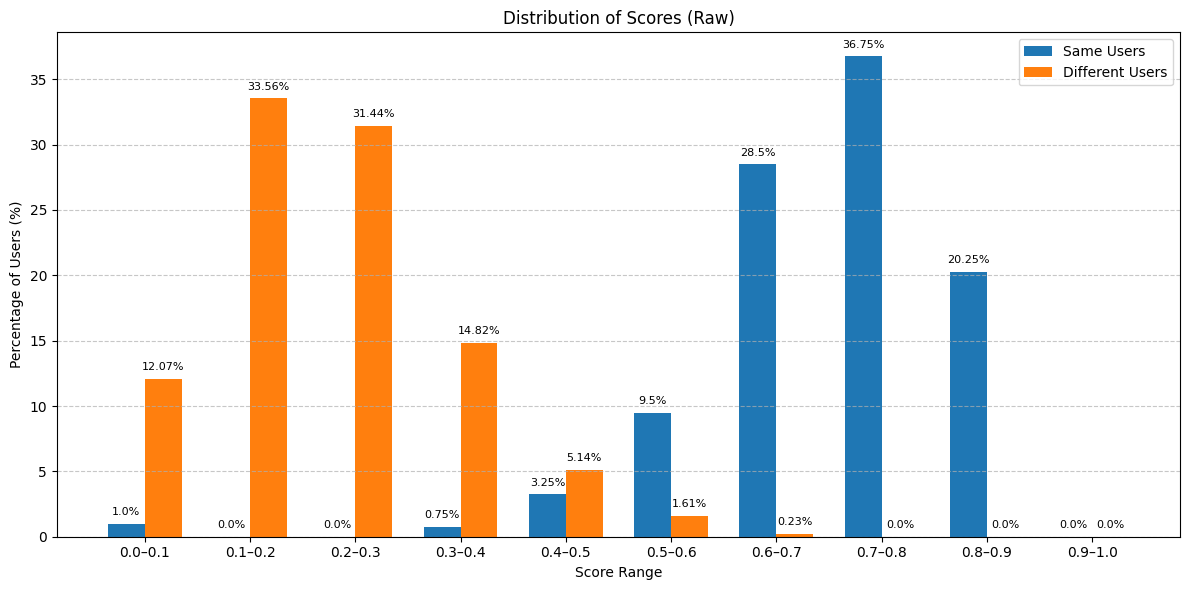

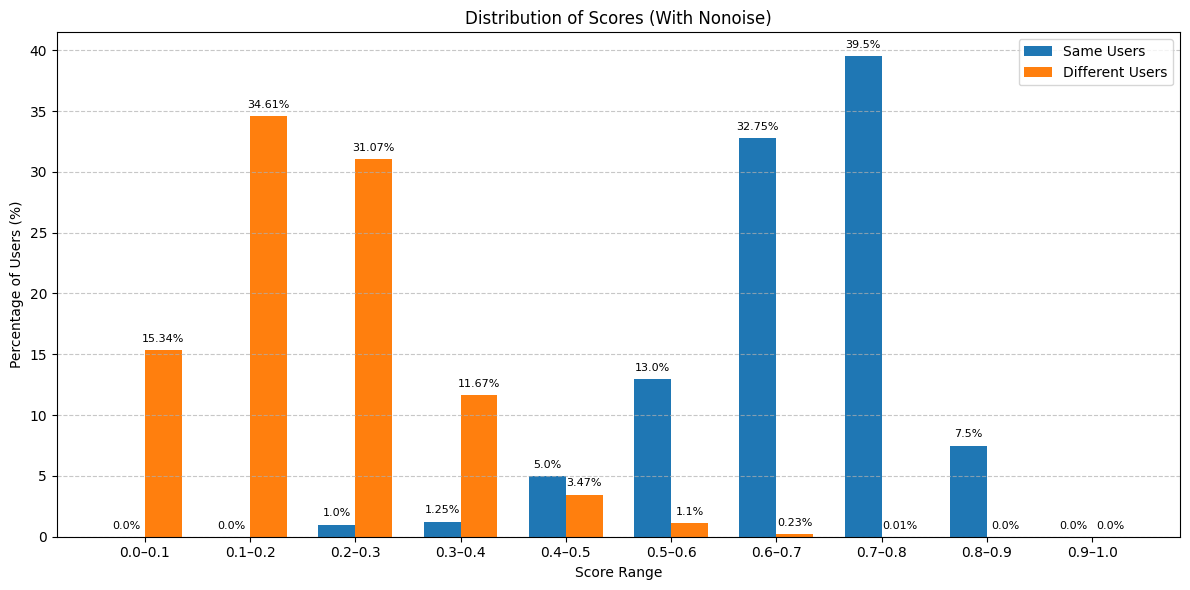

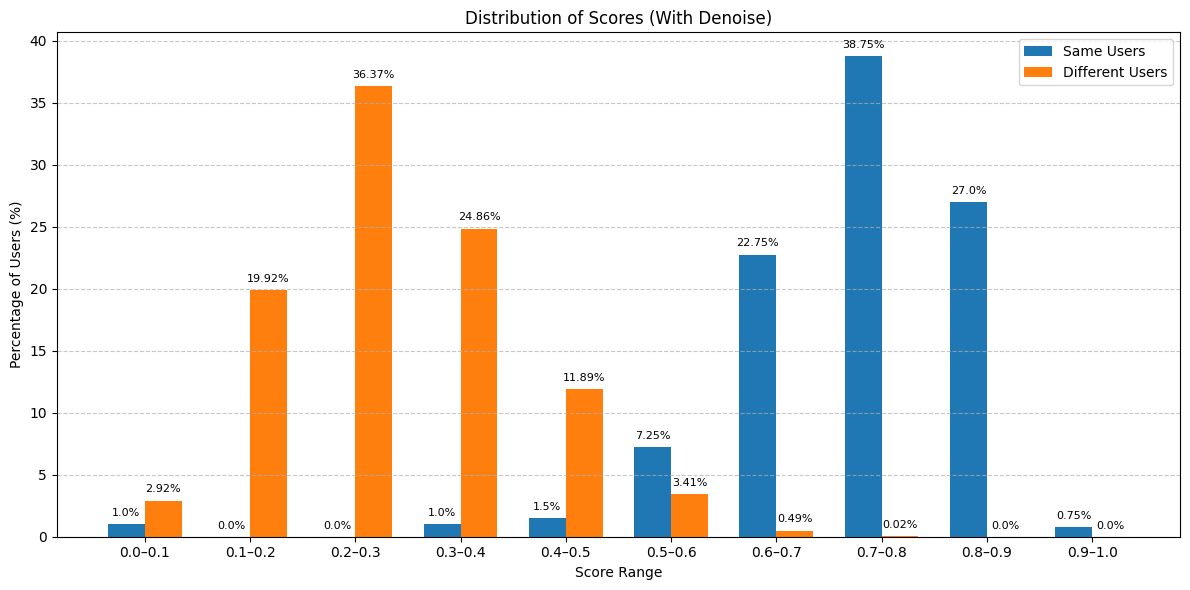

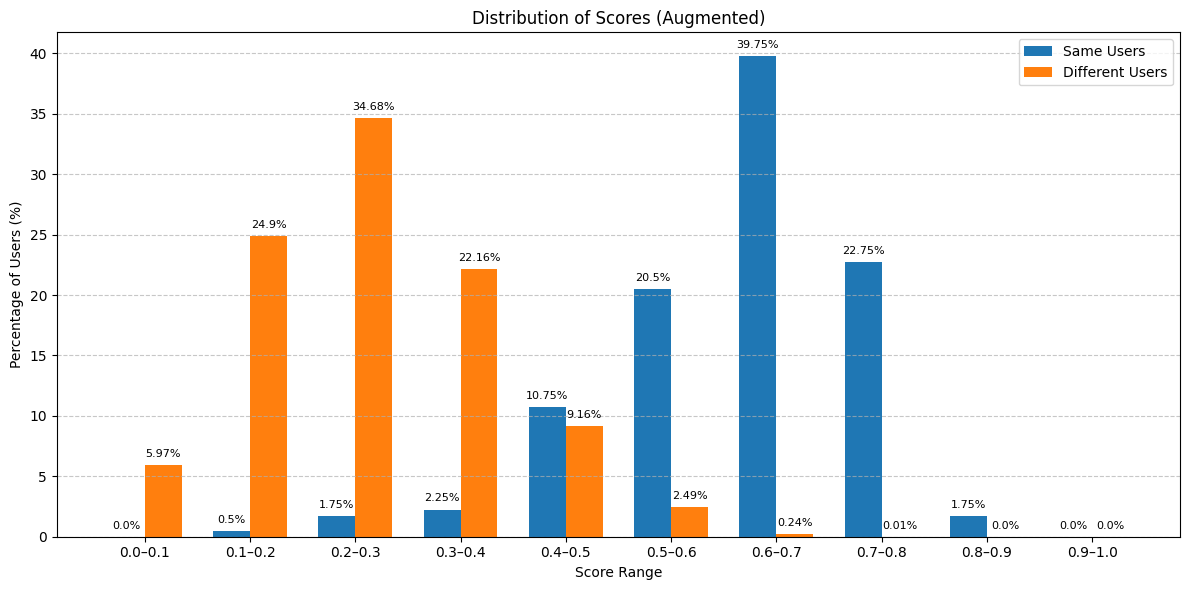

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np  # Ensure numpy is imported

# ------------------------
# Plotting function
# ------------------------

def plot_score_distribution(summary_df, score_col_same, score_col_diff, title):
    plt.figure(figsize=(12, 6))
    
    x = summary_df['Range']
    same = summary_df[score_col_same + ' %']
    diff = summary_df[score_col_diff + ' %']
    
    width = 0.35
    indices = np.arange(len(x))
    
    plt.bar(indices - width / 2, same, width=width, label='Same Users', color='tab:blue')
    plt.bar(indices + width / 2, diff, width=width, label='Different Users', color='tab:orange')
    
    # Adding percentage labels on bars
    for i, (s, d) in enumerate(zip(same, diff)):
        plt.text(i - width / 2, s + 0.5, f'{s}%', ha='center', va='bottom', fontsize=8)
        plt.text(i + width / 2, d + 0.5, f'{d}%', ha='center', va='bottom', fontsize=8)
    
    plt.xlabel('Score Range')
    plt.ylabel('Percentage of Users (%)')
    plt.title(title)
    plt.xticks(indices, x)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# ------------------------
# Generate plots
# ------------------------

plot_score_distribution(summary_table, 'Same (score)', 'Different (score)', 'Distribution of Scores (Raw)')
plot_score_distribution(summary_table, 'Same (score_with_nonoise)', 'Different (score_with_nonoise)', 'Distribution of Scores (With Nonoise)')
plot_score_distribution(summary_table, 'Same (score_denoise)', 'Different (score_denoise)', 'Distribution of Scores (With Denoise)')
plot_score_distribution(summary_table, 'Same (score_augmented)', 'Different (score_augmented)', 'Distribution of Scores (Augmented)')


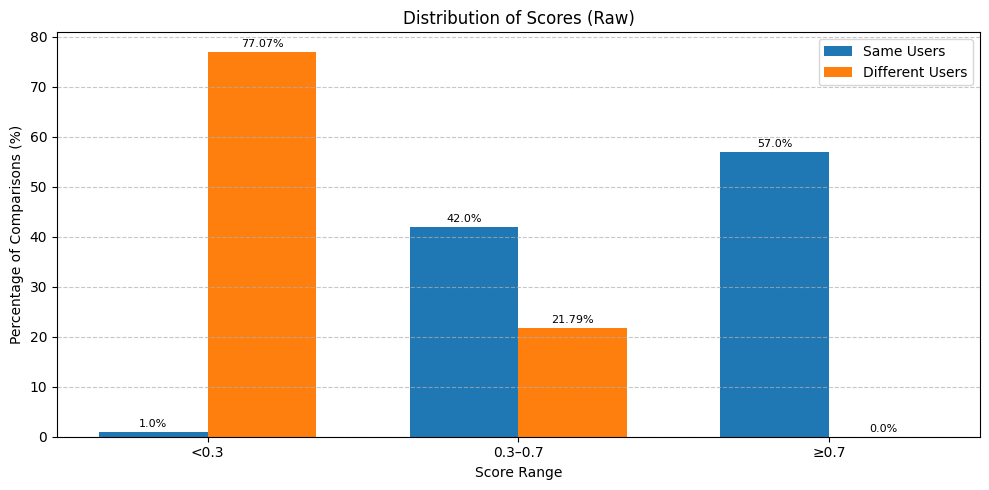

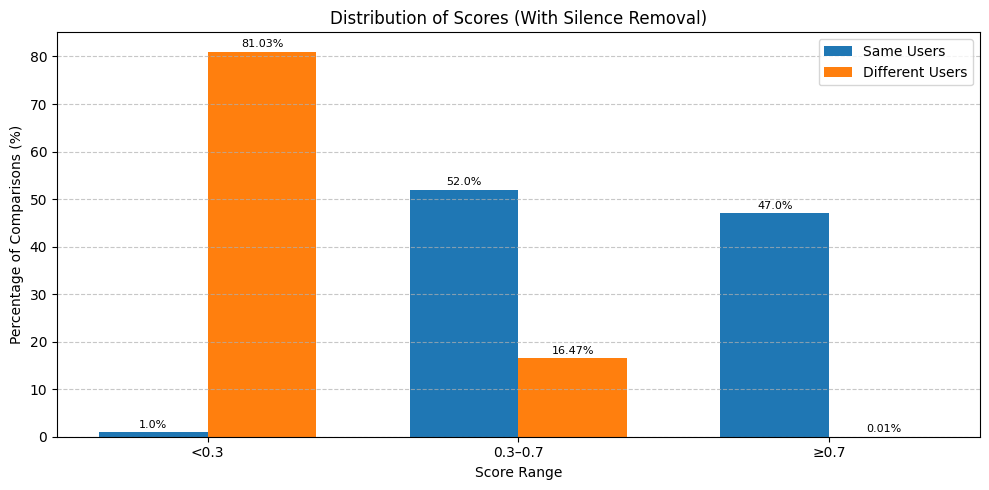

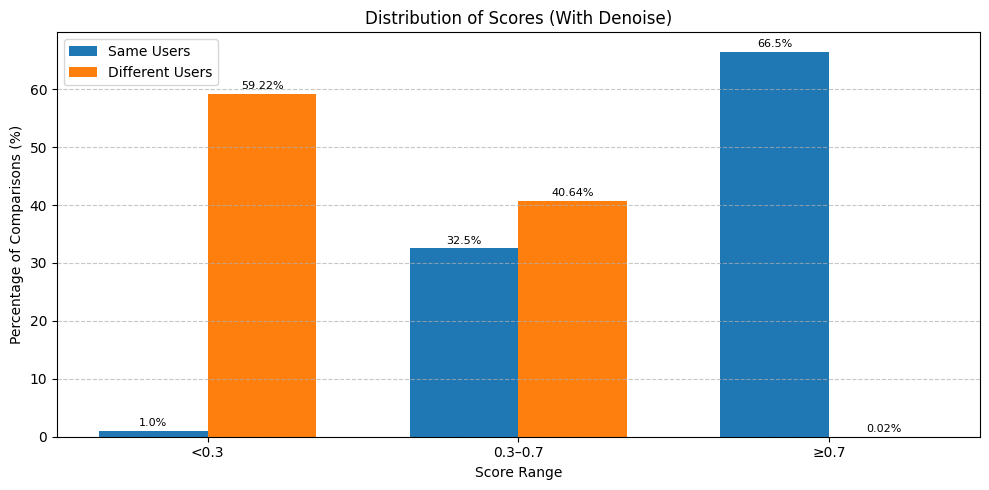

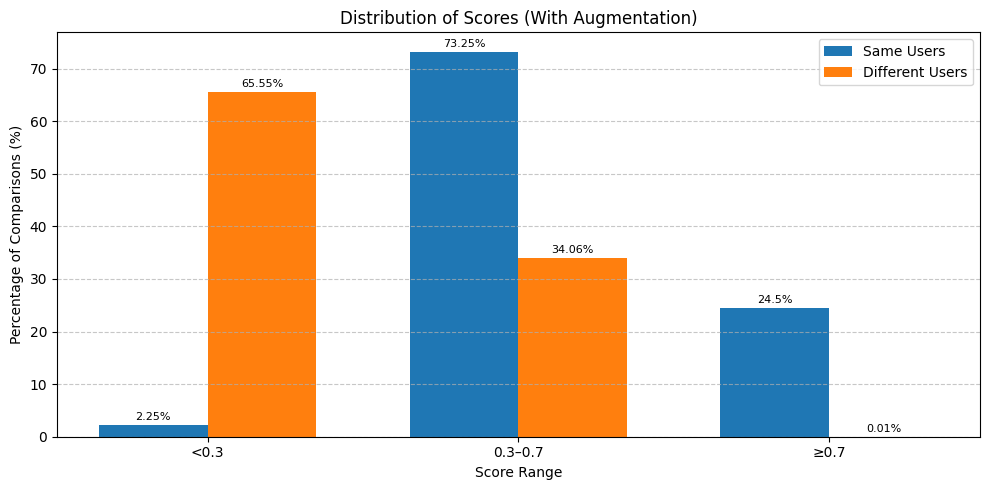

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # Load the CSV
# df = pd.read_csv("Finalverification_scores.csv")

# # Step 1: Clean tensor strings to float
# def extract_float(col):
#     return pd.to_numeric(col.astype(str).str.extract(r'\[(.*?)\]')[0], errors='coerce').fillna(pd.to_numeric(col, errors='coerce'))

df['score'] = extract_float(df['score'])
df['score_with_nonoise'] = extract_float(df['score_with_nonoise'])
df['score_denoise'] = extract_float(df['score_denoise'])
df['score_augmented'] = extract_float(df['score_augmented'])

# Step 2: Define custom bins and labels
bins = [0.0, 0.3, 0.7, 1.0]
labels = ['<0.3', '0.3–0.7', '≥0.7']

# Step 3: Apply binning
df['score_bin'] = pd.cut(df['score'], bins=bins, labels=labels, include_lowest=True)
df['score_with_nonoise_bin'] = pd.cut(df['score_with_nonoise'], bins=bins, labels=labels, include_lowest=True)
df['score_denoise_bin'] = pd.cut(df['score_denoise'], bins=bins, labels=labels, include_lowest=True)
df['score_augmented_bin'] = pd.cut(df['score_augmented'], bins=bins, labels=labels, include_lowest=True)

# Step 4: Count bins for same/different users
def count_bins(df, score_bin_col, relation):
    return df[df['user_relation'] == relation][score_bin_col].value_counts().sort_index()

same_score = count_bins(df, 'score_bin', 'same')
diff_score = count_bins(df, 'score_bin', 'different')
same_nonoise = count_bins(df, 'score_with_nonoise_bin', 'same')
diff_nonoise = count_bins(df, 'score_with_nonoise_bin', 'different')
same_denoise = count_bins(df, 'score_denoise_bin', 'same')
diff_denoise = count_bins(df, 'score_denoise_bin', 'different')
same_augmented = count_bins(df, 'score_augmented_bin', 'same')
diff_augmented = count_bins(df, 'score_augmented_bin', 'different')

# Step 5: Calculate percentages
total_same = len(df[df['user_relation'] == 'same'])
total_diff = len(df[df['user_relation'] == 'different'])

def calc_percent(counts, total):
    return (counts.reindex(labels, fill_value=0).values / total * 100).round(2)

# Step 6: Create summary table
summary_table = pd.DataFrame({
    'Range': labels,

    'Same (score)': same_score.reindex(labels, fill_value=0).values,
    'Same (score) %': calc_percent(same_score, total_same),

    'Different (score)': diff_score.reindex(labels, fill_value=0).values,
    'Different (score) %': calc_percent(diff_score, total_diff),

    'Same (score_with_nonoise)': same_nonoise.reindex(labels, fill_value=0).values,
    'Same (score_with_nonoise) %': calc_percent(same_nonoise, total_same),

    'Different (score_with_nonoise)': diff_nonoise.reindex(labels, fill_value=0).values,
    'Different (score_with_nonoise) %': calc_percent(diff_nonoise, total_diff),

    'Same (score_denoise)': same_denoise.reindex(labels, fill_value=0).values,
    'Same (score_denoise) %': calc_percent(same_denoise, total_same),

    'Different (score_denoise)': diff_denoise.reindex(labels, fill_value=0).values,
    'Different (score_denoise) %': calc_percent(diff_denoise, total_diff),

    'Same (score_augmented)': same_augmented.reindex(labels, fill_value=0).values,
    'Same (score_augmented) %': calc_percent(same_augmented, total_same),

    'Different (score_augmented)': diff_augmented.reindex(labels, fill_value=0).values,
    'Different (score_augmented) %': calc_percent(diff_augmented, total_diff),
})

# Step 7: Plotting function
def plot_score_distribution(summary_df, score_col_same, score_col_diff, title):
    plt.figure(figsize=(10, 5))

    x = summary_df['Range']
    same = summary_df[score_col_same + ' %']
    diff = summary_df[score_col_diff + ' %']

    width = 0.35
    indices = np.arange(len(x))

    plt.bar(indices - width/2, same, width=width, label='Same Users', color='tab:blue')
    plt.bar(indices + width/2, diff, width=width, label='Different Users', color='tab:orange')

    for i, (s, d) in enumerate(zip(same, diff)):
        plt.text(i - width/2, s + 0.5, f'{s}%', ha='center', va='bottom', fontsize=8)
        plt.text(i + width/2, d + 0.5, f'{d}%', ha='center', va='bottom', fontsize=8)

    plt.xlabel('Score Range')
    plt.ylabel('Percentage of Comparisons (%)')
    plt.title(title)
    plt.xticks(indices, x)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Step 8: Plot all distributions
plot_score_distribution(summary_table, 'Same (score)', 'Different (score)', 'Distribution of Scores (Raw)')
plot_score_distribution(summary_table, 'Same (score_with_nonoise)', 'Different (score_with_nonoise)', 'Distribution of Scores (With Silence Removal)')
plot_score_distribution(summary_table, 'Same (score_denoise)', 'Different (score_denoise)', 'Distribution of Scores (With Denoise)')
plot_score_distribution(summary_table, 'Same (score_augmented)', 'Different (score_augmented)', 'Distribution of Scores (With Augmentation)')
